In [69]:
import gensim.downloader as api
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import copy 
import numpy as np


In [4]:
# load model
model = api.load('glove-twitter-200')

[=================================================-] 98.8% 749.2/758.5MB downloaded

In [5]:
with open('./words_eng.txt', 'r') as f:
	wrds = f.readlines()
	wrds = [x.strip('\n') for x in wrds]

In [7]:
# transform words into vectors
words = []
vectors = []

for wrd in wrds:
  try:
    vectors.append(model.word_vec(wrd))
    words.append(wrd)
  except KeyError:
    continue

In [8]:
distance = pdist(vectors, 'cosine')
sq = squareform(distance)

In [158]:
# Takes similarity matrix, words, threshhold number and minimal number of words in cluster
# Returns clusters in a dictionary {cluster name: list of words in cluster}
def similarity_threshhold(squareform_matrix, words_list, threshhold, min_in_cluster):
  dict_of_words = {}
  vals = []
  for word in words:
    l = []
    idx1 = words.index(word)
    if word not in vals:
      for vec in sq[idx1]:
        if vec < threshhold:
          idx2 = sq[idx1].tolist().index(vec)
          if words[idx2] not in vals:
            l.append(words[idx2])
            vals.append(words[idx2])
      dict_of_words[word] = [x for x in set(l) if len(set(l)) >= min_in_cluster]
  return dict_of_words

dict_of_words = similarity_threshhold(sq, words, 0.70, 4)

In [159]:
lenth = {}
for x in dict_of_words:
  if len(dict_of_words[x]) > 0:
    lenth[x] = len(dict_of_words[x])
# (cluster name, words in cluster)
print(sorted(lenth.items(), key=lambda x: x[1], reverse=True))
# number of words in all clusters 
print(sum(lenth.values()))

[('ham', 97), ('goose', 26), ('apricot', 19), ('prepare', 16), ('liquid', 15), ('grandmother', 11), ('picnic', 10), ('appetite', 9), ('waiter', 8), ('porridge', 5), ('blackberry', 5), ('nine', 4)]
225


In [160]:
df = pd.DataFrame(columns= ['word', 'vector', 'target'])
for key, v_l in dict_of_words.items():
  for val in v_l:
    df_row = pd.DataFrame([[val, vectors[words.index(val)], key]], columns= ['word', 'vector', 'target'])
    df = pd.concat([df_row, df], ignore_index=True)
# add columns for tsne values
df['tsne1'], df['tsne2'] = '', ''

In [162]:
tsne = TSNE(n_components=2, n_jobs=-1, perplexity=2)
X_tsne = tsne.fit_transform(np.stack(df.vector))

In [163]:
# add tsne values in df
for row in range(len(X_tsne)):
  df.iloc[row, 3] = X_tsne[row][0]
  df.iloc[row, 4] = X_tsne[row][1]

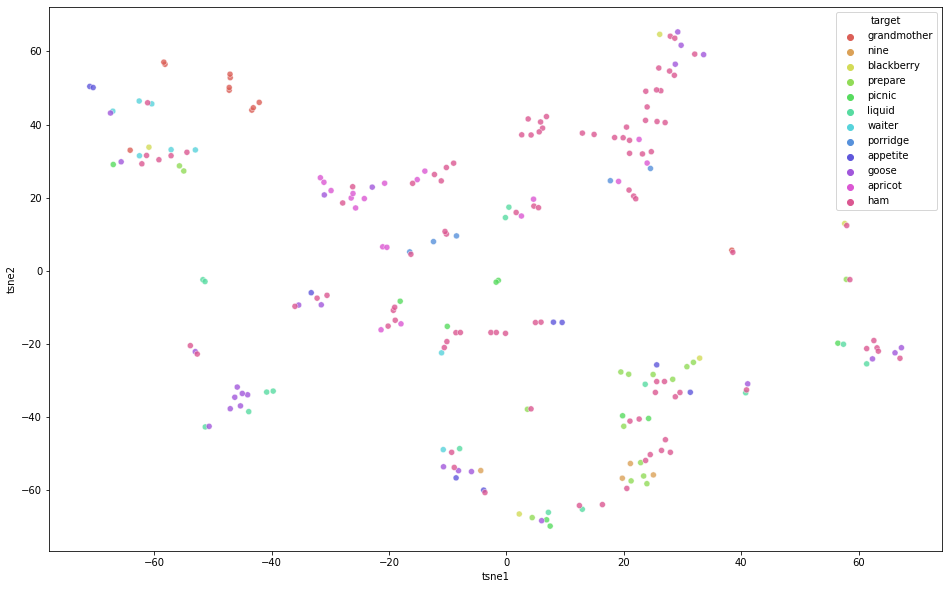

In [165]:
cluster_names = df.target.value_counts().index

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="target",
    palette=sns.color_palette("hls", len(cluster_names)),
    data=df,
    legend="full",
    alpha=0.8
)